In [1]:
# Python >=3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >=0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/wm811k-wafer-map/LSWMD.pkl


In [2]:
# data summary

df= pd.read_pickle('/kaggle/input/wm811k-wafer-map/LSWMD.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


811,457개의 wafer map과 dieSize, lotName, waferIndex 등의 정보로 이루어짐.

In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


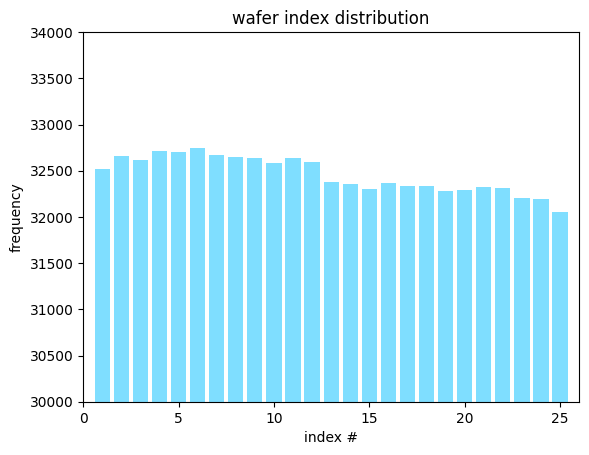

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='deepskyblue', align='center', alpha=0.5)
plt.title("wafer index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

wafer index 간의 데이터 분포가 고르지 않으며, wafer index feature는 분류에 필요없음.

In [6]:
df=df.drop(['waferIndex'], axis=1)

die size가 다 다름.

wafer map 차원 검사를 위한 새로운 변수 'waferMapDim'을 만들어서 사용.

In [7]:
# 데이터프레임에 'waferMapDim' 열 추가
def find_dim(x):
    dim0=np.size(x, axis=0)
    dim1=np.size(x, axis=1)
    return dim0, dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(10)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
667342,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot41552,[],[],"(32, 29)"
41615,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2,...",515.0,lot3645,[],[],"(25, 27)"
783483,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46406,[],[],"(42, 44)"
310678,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",8147.0,lot18900,[],[],"(101, 103)"
801056,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",562.0,lot47118,[[Test]],[[none]],"(29, 26)"
534689,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot33411,[],[],"(32, 29)"
276467,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot17005,[],[],"(52, 59)"
182056,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3601.0,lot11592,[],[],"(75, 61)"
501597,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,...",710.0,lot31178,[],[],"(32, 29)"
256122,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3746.0,lot15866,[],[],"(67, 71)"


In [8]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [9]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

wafer map의 max, min dimension 값이 다르다는 것은
wafer map의 dimension, 혹은 이미지 크기가 다르다는 것.

또한 632개의 다른 size가 있음.

In [10]:
# 'failureNum' 및 'trainTestNum' 열의 값을 각각 'mapping_type' 및 'mapping_traintest'에 따라 새로운 값으로 대체
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest={'Training':0, 'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [11]:
tol_wafers=df.shape[0]
tol_wafers # 데이터프레임에 있는 모든 웨이퍼의 수

811457

In [12]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel = df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

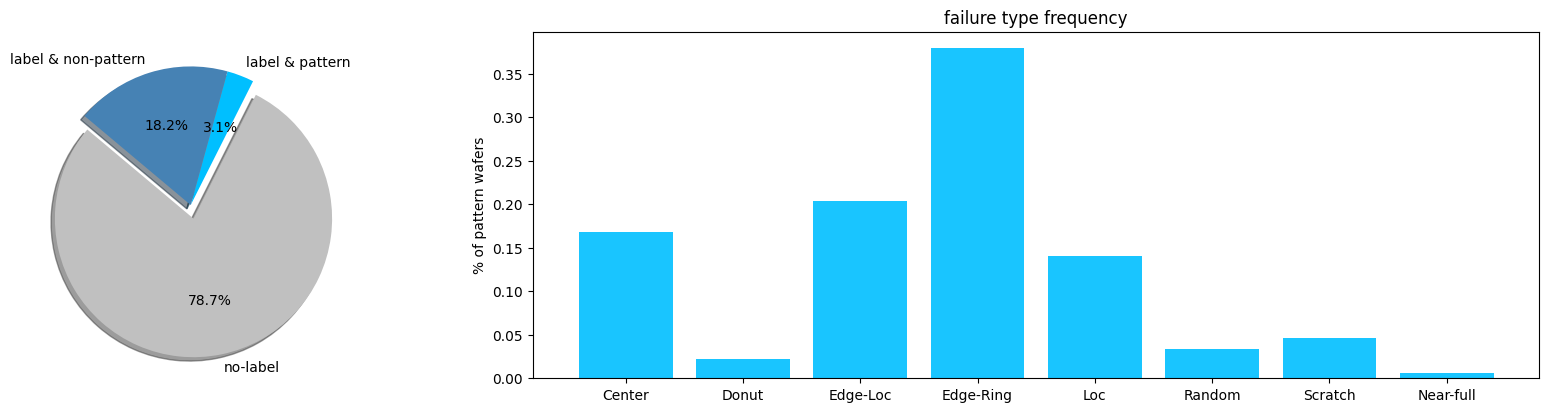

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'deepskyblue', 'steelblue']
explode = (0.1, 0, 0)
labels = ['no-label','label & pattern','label & non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='deepskyblue', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

172,950개의 wafer에 label이 있는 반면, 나머지 78.7%의 wafer는 failureType label이 없음.
라벨링된 21.3%의 wafer 중 failure pattern을 가진 wafer는 3.1%(25,519개) 뿐으로, 이 25,519개에 집중할 것.

두 번째 사진은 각 패턴의 비율이 제각각이므로 failure type에 대한 불균형 분포를 보임.

그 중에서 식각 공정에서 가장 중요한 요소 중 마스크 정렬의 오차로 발생하는 donut, edge-ring, edge-loc에 대한 데이터만 추출.

In [31]:
# (26,26)의 해상도를 갖는 wafer 추출

sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue

    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [32]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


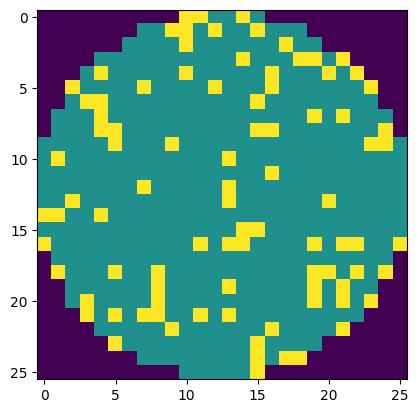

Faulty case : ['none'] 


In [33]:
# 첫 번째 wafer 데이터 시각화
plt.imshow(x[0])
plt.show()

print('Faulty case : {} '.format(y[0]))

In [34]:
x = x.reshape((-1, 26, 26, 1))

In [35]:
# 결함 종류별로 데이터 개수 확인
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']
Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [36]:
# wafer data의 각 픽셀에는 0: wafer가 아님, 1: 정상, 2: 결함을 나타내는 범주형 변수가 있음
# 변수들을 각 채널에 따라 원핫인코딩
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1
            
# 변환된 이미지 데이터 차원 확인
new_x.shape

(14366, 26, 26, 3)

In [37]:
# 데이터 증강으로 클래스 불균형 해결
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras import layers, models

epoch=30
batch_size=1024

# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [38]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/30
15/15 - 13s - loss: 0.1473 - 13s/epoch - 864ms/step
Epoch 2/30
15/15 - 12s - loss: 0.0965 - 12s/epoch - 770ms/step
Epoch 3/30
15/15 - 12s - loss: 0.0825 - 12s/epoch - 799ms/step
Epoch 4/30
15/15 - 12s - loss: 0.0695 - 12s/epoch - 775ms/step
Epoch 5/30
15/15 - 11s - loss: 0.0601 - 11s/epoch - 763ms/step
Epoch 6/30
15/15 - 11s - loss: 0.0537 - 11s/epoch - 765ms/step
Epoch 7/30
15/15 - 12s - loss: 0.0481 - 12s/epoch - 784ms/step
Epoch 8/30
15/15 - 11s - loss: 0.0427 - 11s/epoch - 758ms/step
Epoch 9/30
15/15 - 12s - loss: 0.0375 - 12s/epoch - 779ms/step
Epoch 10/30
15/15 - 12s - loss: 0.0328 - 12s/epoch - 768ms/step
Epoch 11/30
15/15 - 11s - loss: 0.0289 - 11s/epoch - 765ms/step
Epoch 12/30
15/15 - 12s - loss: 0.0258 - 12s/epoch - 781ms/step
Epoch 13/30
15/15 - 11s - loss: 0.0232 - 11s/epoch - 763ms/step
Epoch 14/30
15/15 - 11s - loss: 0.0211 - 11s/epoch - 764ms/step
Epoch 15/30
15/15 - 12s - loss: 0.0194 - 12s/epoch - 778ms/step
Epoch 16/30
15/15 - 12s - loss: 0.0179 - 12s/epoc

In [39]:
encoder = models.Model(input_tensor, latent_vector)

In [40]:
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [41]:
# original faulty wafer 엔코딩
encoded_x = encoder.predict(new_x)

449/449 [==============================] - 2s 5ms/step


In [42]:
# 노이즈 추가
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

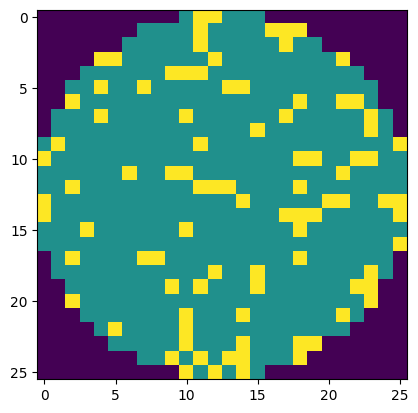

In [43]:
# original faulty wafer data 시각화
plt.imshow(np.argmax(new_x[3], axis=2))

449/449 [==============================] - 4s 9ms/step


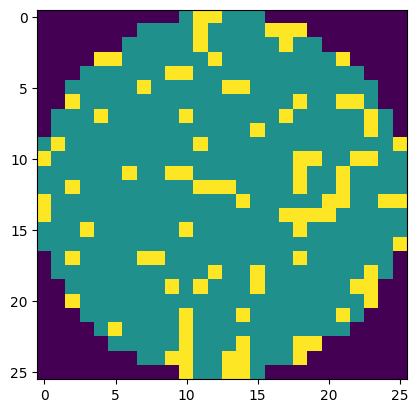

In [44]:
# new noised faulty wafer data 시각화
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [45]:
# 100개 데이터 증강
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
        
    # make wafer until total # of wafer to 100
    for i in range((100//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)       
    
    # return date without 1st dummy data
    return gen_x[1:], gen_y[1:]

In [46]:
# 모든 faulty 데이터를 증강
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

3/3 [==============================] - 0s 11ms/step


In [47]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (15768, 26, 26, 3), new_y shape : (15768, 1)


In [48]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 270
Donut : 102
Edge-Loc : 592
Edge-Ring : 155
Loc : 594
Near-full : 128
Random : 222
Scratch : 216
none : 13489


In [49]:
# 대체하지 않고 인덱스 선택
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=83, replace=False)]

In [50]:
# 지정한 인덱스 데이터 제거
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [51]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (15685, 26, 26, 3), new_y shape : (15685, 1)


In [52]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 270
Donut : 102
Edge-Loc : 592
Edge-Ring : 155
Loc : 594
Near-full : 128
Random : 222
Scratch : 216
none : 13406


In [53]:
from keras.utils import to_categorical
# 문자 라벨을 정량적 라벨로
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# 원핫인코딩
new_y = to_categorical(new_y)

In [64]:
#  train, test 데이터 분리
from sklearn.model_selection import train_test_split

min_samples = min(new_x.shape[0], new_y.shape[0])

# new_x와 new_y의 크기를 맞춤
new_x = new_x[:min_samples]
new_y = new_y[:min_samples]

x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.2,
                                                    random_state=2019)

In [65]:
# 'donut', 'edge-ring', 'edge-loc' 이외의 데이터 필터링
filtered_indices = np.isin(np.argmax(y_train, axis=1), [1, 3, 2])
x_train_filtered = x_train[filtered_indices]
y_train_filtered = y_train[filtered_indices]

filtered_indices = np.isin(np.argmax(y_test, axis=1), [1, 3, 2])
x_test_filtered = x_test[filtered_indices]
y_test_filtered = y_test[filtered_indices]

print('Filtered Train x : {}, y : {}'.format(x_train_filtered.shape, y_train_filtered.shape))
print('Filtered Test x: {}, y : {}'.format(x_test_filtered.shape, y_test_filtered.shape))

Filtered Train x : (685, 26, 26, 3), y : (685, 9)
Filtered Test x: (164, 26, 26, 3), y : (164, 9)


In [69]:
# Functional API 사용하여 간단한 합성곱 신경망 형태의 모델 구축
def create_model():
    input_shape = (26, 26, 3)
    input_tensor = Input(input_shape)

    conv_1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input_tensor)
    conv_2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv_1)
    conv_3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv_2)

    flat = layers.Flatten()(conv_3)

    dense_1 = layers.Dense(512, activation='relu')(flat)
    dense_2 = layers.Dense(128, activation='relu')(dense_1)
    output_tensor = layers.Dense(9, activation='softmax')(dense_2)

    model = models.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [70]:
# 3-Fold 교차 검증 수행
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

losses = []
accuracies = []

# Loop through folds
for train_index, test_index in kf.split(x_train_filtered):
    x_train_filtered_fold, x_test_filtered_fold = x_train_filtered[train_index], x_train_filtered[test_index]
    y_train_filtered_fold, y_test_filtered_fold = y_train_filtered[train_index], y_train_filtered[test_index]
    
    model = create_model()
    
    # Train the model on the training fold
    model.fit(x_train_filtered_fold, y_train_filtered_fold, epochs=epoch, batch_size=batch_size, verbose=0)
    
    # Evaluate the model on the test fold
    evaluation_result = model.evaluate(x_test_filtered_fold, y_test_filtered_fold, verbose=0)
    
    # Append results to lists
    losses.append(evaluation_result[0])
    accuracies.append(evaluation_result[1])

# Display average results
print("Average Loss:", np.mean(losses))
print("Average Accuracy:", np.mean(accuracies))

Average Loss: 0.03880374816556772
Average Accuracy: 0.9897724588712057


In [71]:
# 간단하게 fit() 메서드를 호출하여 모델 평가
history = model.fit(x_train_filtered, y_train_filtered,validation_data=(x_test_filtered, y_test_filtered),epochs=epoch,batch_size=batch_size)

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 0.0297 - accuracy: 0.9898 - val_loss: 0.0381 - val_accuracy: 0.9878
Epoch 2/30
1/1 [==============================] - 4s 4s/step - loss: 0.0341 - accuracy: 0.9869 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 3/30
1/1 [==============================] - 4s 4s/step - loss: 0.0251 - accuracy: 0.9942 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 4/30
1/1 [==============================] - 4s 4s/step - loss: 0.0258 - accuracy: 0.9942 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 5/30
1/1 [==============================] - 3s 3s/step - loss: 0.0256 - accuracy: 0.9942 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 6/30
1/1 [==============================] - 3s 3s/step - loss: 0.0197 - accuracy: 0.9942 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 7/30
1/1 [==============================] - 4s 4s/step - loss: 0.0204 - accuracy: 0.9927 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 8/30
1/1 [=========================

In [73]:
score = model.evaluate(x_test_filtered, y_test_filtered)

print('Testing Accuracy:',score)

6/6 [==============================] - 0s 71ms/step - loss: 0.0015 - accuracy: 1.0000
Testing Accuracy: [0.0015253496821969748, 1.0]


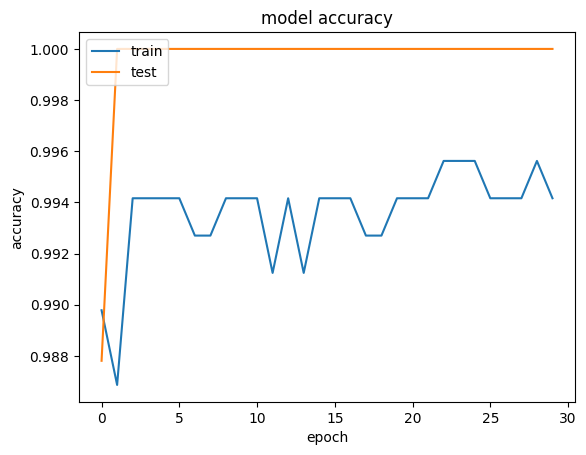

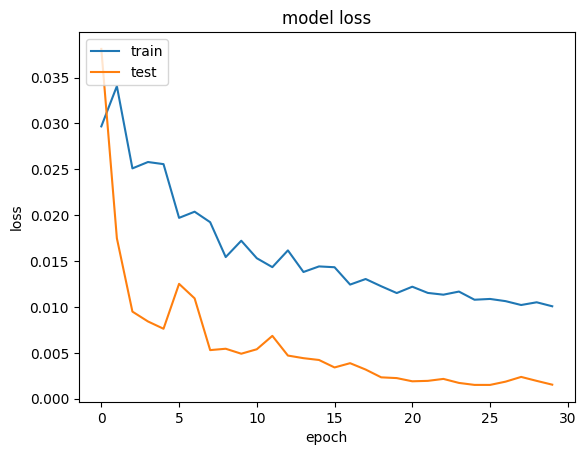

In [76]:
# accuracy plot 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()